## Evaluating SCSS-Net predictions on years 1996 - 2021
In this notebook, we provide code that segments coronal holes or active regions with SCSS-Net throughout 25 years

In [1]:
import sys, os
sys.path.append('../src/')

In [2]:
import zipfile
import numpy as np
import glob
from datetime import datetime
from PIL import Image, ImageDraw
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
import tensorflow
from keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm

In [3]:
from model_scss_net import scss_net
from metrics import dice_np, iou_np, dice, iou
from utils import plot_imgs, plot_metrics, plot_top, create_contours

In [5]:
IMG_SIZE = 256  # resize imgs to 256x256
BATCH_SIZE = 20 # set batch size
SEED = 42       # set seed for reproducibility
EPOCHS = 100    # Set number of epochs

# specify model filename, you should rewrite MODEL_NAME as yours preferrings
MODEL_NAME = "model_filename"
model_filename = f"{MODEL_NAME}.h5"  

In [6]:
# loading imgs from 96-21, 195A (for CH) or 171A (for AR)
imgs_test = glob.glob("../data/imgs_171_96-21/*.png")

print(f"Imgs number = {len(imgs_test)}")

imgs_test_list = []
for image in imgs_test:
    imgs_test_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))



Imgs number = 7985


In [7]:
# Normalization from (0; 255) to (0; 1)
x_test = np.asarray(imgs_test_list, dtype=np.float32)/255

# Reshape to (n_imgs, height, width, channels)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [8]:
# input shape should be (256, 256, 1)
input_shape = x_test[0].shape
print(f"Input shape: {input_shape}\n")

Input shape: (256, 256, 1)



## Predictions 96-21

In [9]:
# Load model architecture with optimal parameteres
model = scss_net( 
    input_shape,
    filters=32,       
    layers=4,
    batch_norm=True,
    drop_prob=0.5)

# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  
    metrics=[iou, dice])

In [10]:
model.load_weights("ar_model.h5")

In [11]:
y_pred = model.predict(x_test)

2023-04-02 10:43:41.474357: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


250/250 [==============================] - 1065s 4s/step


<function matplotlib.pyplot.show(close=None, block=None)>

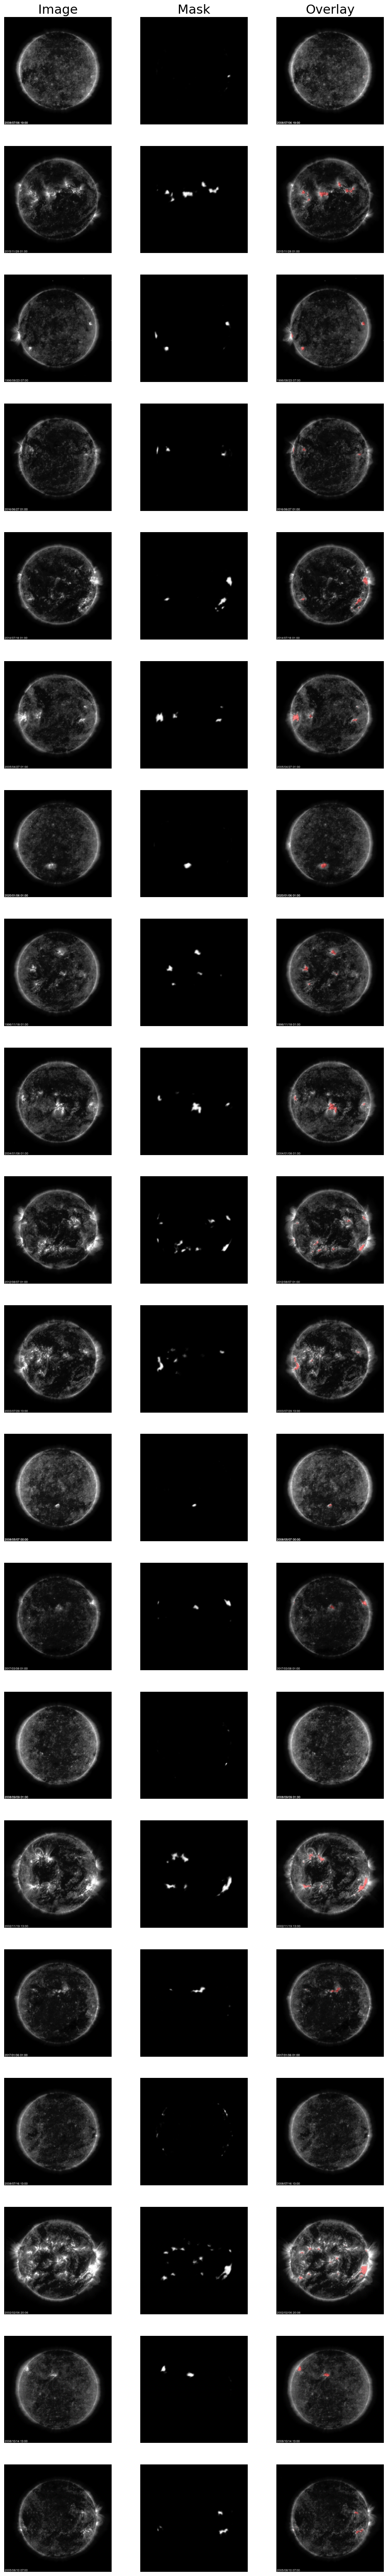

In [15]:
#show predictions
plot_imgs(imgs=x_test, masks=y_pred, n_imgs=20).show

In [16]:
dates = []
for name in glob.glob("../data/imgs_171_96-21/*.png"):
    name_clean = name[-29:]
    tostrip = name_clean[0:8]
    date = datetime.strptime(tostrip, '%Y%m%d')
    dates.append(date)

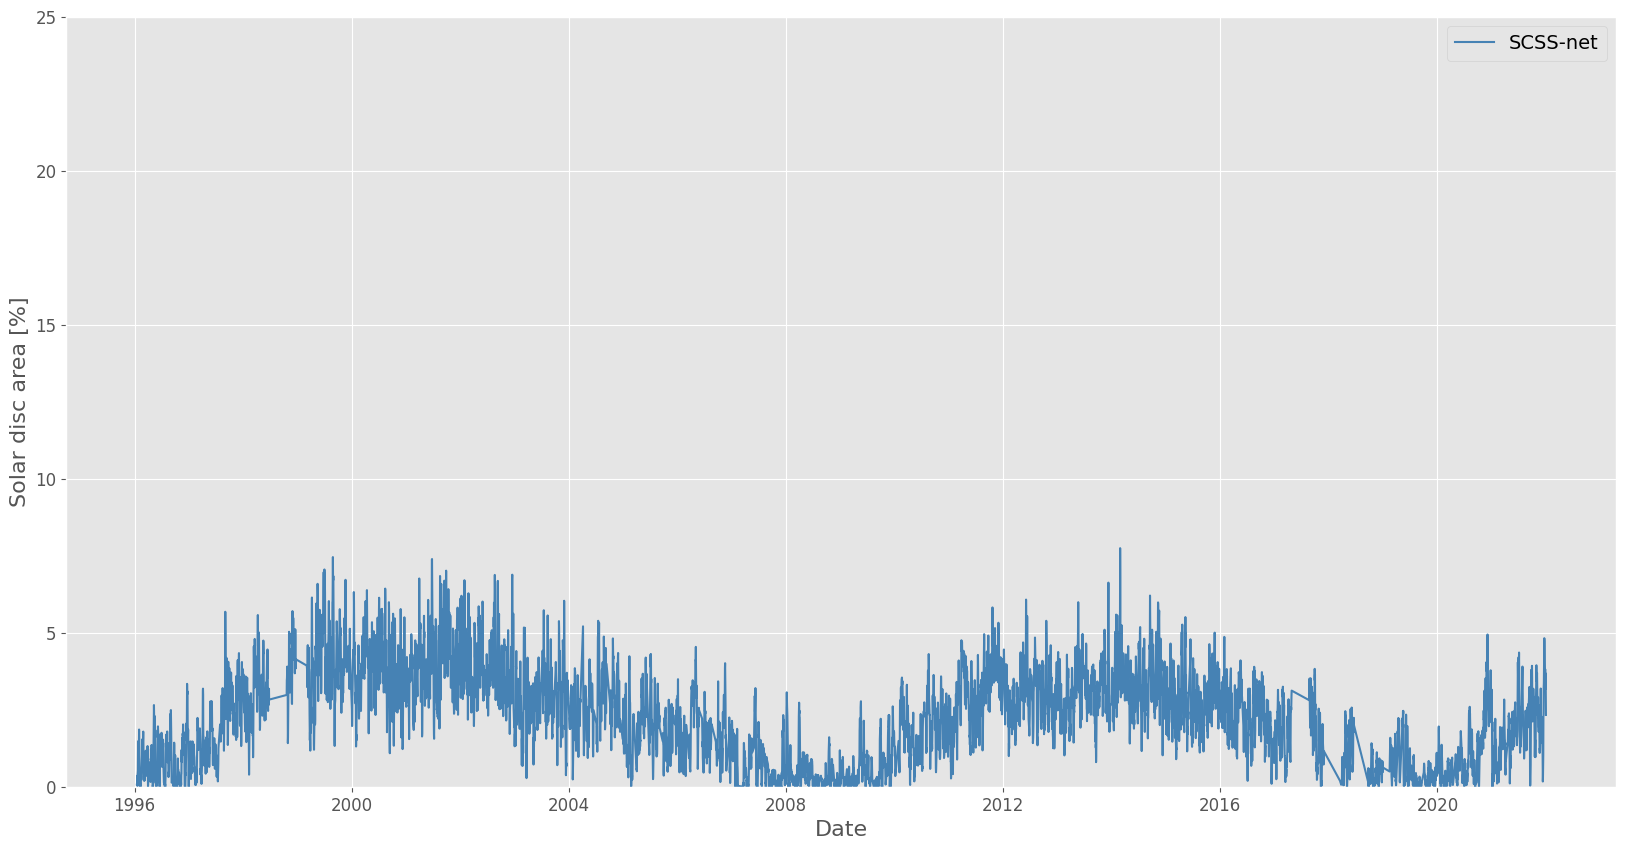

In [21]:
limb_total = 28326
predicted_area = [(((1 * (tmp > 0.1)).sum() * 100)/limb_total) for tmp in y_pred]
dates_sorted, predicted_area_sorted = zip(*sorted(zip(dates, predicted_area)))

plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 10))
plt.xlabel("Date", fontsize=16)
plt.ylabel("Solar disc area [%]", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0, 25])
plt.plot(dates_sorted, predicted_area_sorted, label='SCSS-net', color='steelblue')
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [22]:
fig.savefig('AR_graf.jpg')

In [24]:
# this code was used to create imgs with highlighted segmentations.
# those images were then used to create 2 16min. videos to show all images with segmentations for 25 years
# with small edit, one could create black and white annotations of events
for i, prediction in enumerate(y_pred):
    annotations = create_contours(prediction, target_size = (1024,1024))
    image_name_clean = imgs_test[i][-29:-4]

    img = Image.open("/Users/majirky/Desktop/slnko_ar/arfotky_96-21/" + image_name_clean + ".png").resize((1024, 1024))
    # comment line above and uncomment line bellow to create black bg
    # img = Image.new("RGBA", [IMG_SIZE, IMG_SIZE], color = "BLACK")

    draw = ImageDraw.Draw(img)

    for annotation in annotations:
        draw.polygon(annotation, outline="red", width=4)
        # comment line above and uncomment line bellow to create white annotations of events
        # draw.polygon(annotation, outline="white", width=4, fill="white")

    img.save("/Users/majirky/Desktop/slnko_ar/AR_segmentacie_96-21/" + image_name_clean + ".jpg")